In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import datetime
from sklearn import linear_model
from matplotlib import pyplot as plt

In [2]:
sessions_df = pd.read_json("./../data/raw/sessions.jsonl", lines=True)
sessions_df.set_index('session_id', inplace=True)

In [3]:
def create_weeks(df):
    dates = df['timestamp']
    dates = pd.to_datetime(dates)
    dates = dates.dt.to_period('W')
    dates = dates.drop_duplicates()
    dates = dates.sort_values()
    return dates

In [4]:
def calculate_week_number(date = datetime.date.today()):
    first_date = create_weeks(sessions_df).values[0].start_time.date()
    return (date - first_date).days//7

In [5]:
def product_bought(product_id, df, dates):
    product_amount = df[(df['event_type'] == "BUY_PRODUCT") & (df['product_id'] == product_id)]
    daterange_df = pd.DataFrame()
    time_list = [(dates.values[i].start_time, dates.values[i].end_time) for i in range(len(dates))]
    daterange_df['count'] = [product_amount['timestamp'].between(s, e).sum() for s, e in time_list]
    return daterange_df

In [6]:
def prepare_dataframe(df):
    dates = create_weeks(df)
    weeks = dates.values
    df3 = pd.DataFrame()
    df3['date'] = [weeks[i].start_time for i in range(len(weeks))]
    df2 = pd.DataFrame(index = df3['date'])
    df2['weeks_from_start'] = ((df2.index - df2.index[0]).days)//7
    return df2, dates

In [7]:
def prepare_data(product_id, df, source_df, dates):
    x = df['weeks_from_start'].values.reshape(-1, 1)
    y = product_bought(product_id, source_df, dates)['count'].values
    return x, y

In [8]:
df, dates = prepare_dataframe(sessions_df)
x, y = prepare_data(1114, df, sessions_df, dates)

In [15]:
df # weeks from start
y = product_bought(1114, sessions_df, dates) # ile produktu o danym id zostało kupione w danym tygodniu

In [19]:
y

,count
0,0
1,0
2,0
3,0
4,0
...,...
119,0
120,0
121,0
122,0


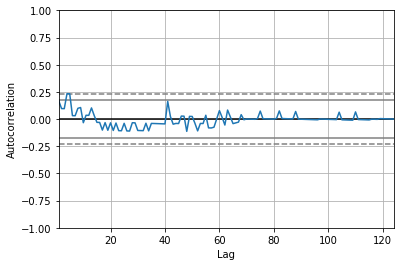

In [24]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y['count'])
plt.show()

In [33]:
#!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA


In [34]:
model=ARIMA(y['count'],order=(1,1,1))
model_fit=model.fit()

In [35]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                  124
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -41.714
Date:                Mon, 10 Jan 2022   AIC                             89.428
Time:                        14:27:35   BIC                             97.864
Sample:                             0   HQIC                            92.854
                                - 124                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0225      0.080      0.283      0.778      -0.134       0.179
ma.L1         -0.8580      0.034    -25.226      0.000      -0.925      -0.791
sigma2         0.1142      0.008     13.666      0.000       0.098       0.131
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               282.42
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             2.22
Prob(H) (two-sided):                  0.85   Kurtosis:                         8.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

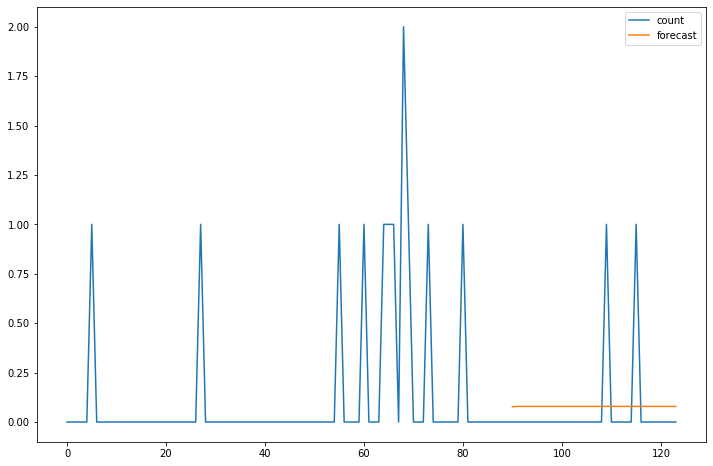

In [37]:
y['forecast']=model_fit.predict(start=90,end=150,dynamic=True)
y[['count','forecast']].plot(figsize=(12,8))